# Reddit Comment Classification Model

This notebook implements a random forest model to classify comments based on sentiment analysis.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load preprocessed data

In [2]:
df = pd.read_csv("data/processed/comments_lang_en.csv")

## Parameters

In [3]:
# List of offensive words for pseudo-labeling
bad_words = [
    "idiot", "stupid", "moron", "hate", "trash", "kill", "fuck", "dumb",
    "loser", "shut up", "disgusting", "ugly", "worthless", "pathetic",
    "suck", "annoying", "nonsense", "fool", "jerk", "bastard", "crap", "damn"
]

def pseudo_label(text):
    """Assigns a pseudo-label of 1 if any bad word is found in the text, else 0."""
    text = str(text).lower()
    return 1 if any(bad in text for bad in bad_words) else 0

# Apply pseudo-labeling to the 'text_ml' column
df["target"] = df["text_ml"].apply(pseudo_label)

## TF-IDF + VADER features

In [4]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["text_ml"].fillna(""))

# Combine TF-IDF features with VADER sentiment scores
vader_feats = df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]].fillna(0).values
# Final feature matrix
X = np.hstack((X_tfidf.toarray(), vader_feats))
# Target variable
y = df["target"]

## Train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest model

In [6]:
# Model training
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
# Predictions
y_pred = model.predict(X_test)

## Model Performance

In [7]:
# Classification report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2538
           1       1.00      0.40      0.58        94

    accuracy                           0.98      2632
   macro avg       0.99      0.70      0.78      2632
weighted avg       0.98      0.98      0.97      2632



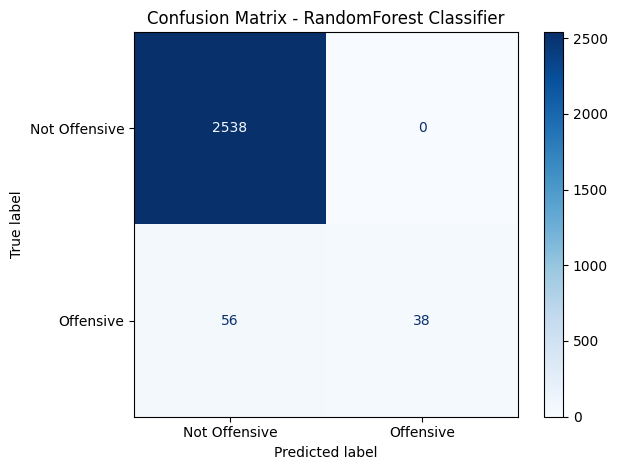

In [8]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Offensive","Offensive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RandomForest Classifier")
plt.tight_layout()
plt.savefig("data/processed/figs/confusion_matrix.png", dpi=150)
plt.show()